# 1_data_preparation

In [1]:
model_name = "ResNeXt101"  # 选择模型 [VGG16, resnet50, ViT-b, ResNeXt50, ResNext101]
pretrained_status = True # 是否使用预训练权重 [True, False]
criterion = "BCE" # [BCE, ASL]

In [2]:
import subprocess
import os

if model_name == "ViT-b": 
    result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
    output = result.stdout
    for line in output.splitlines():
        if '=' in line:
            var, value = line.split('=', 1)
            os.environ[var] = value

## 1.1 检查数据集

In [3]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('../data/RSMLR/trainval.csv')

label_column = 'IMAGE\LABEL'

# 检查是否存在负样本
negative_samples = df[df[label_column] == 0]

# 打印负样本数量和一些负样本的信息（可选）
print("Negative samples count:", len(negative_samples))
print("Example negative samples:")
print(negative_samples.head())


Negative samples count: 0
Example negative samples:
Empty DataFrame
Columns: [IMAGE\LABEL, BareLand, BasketballCourt, Beach, CultivatedLand, FactoryBuilding, FootballField, ForestLand, Grassland, GreenNetwork, Greenhouse, Highway, Lakes, Mulch, Park, PhotovoltaicLand, Quarry, Railway, ResidentialArea, Rivers, SolidWaste, ThreshingGround(Square)]
Index: []

[0 rows x 22 columns]


## 1.2 重写Dataset函数

In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image

class MultiSceneDataset(Dataset):
    def __init__(self, data_dir='RSMLR', train=True, aug_prob=0.5, img_mean=(0.485, 0.456, 0.406),
                 img_std=(0.229, 0.224, 0.225)):
        self.data_dir = data_dir
        self.train = train
        
        self.aug = train # 是否进行数据增强
        self.aug_prob = aug_prob
        
        self.img_mean = img_mean
        self.img_std = img_std
        
        # 根据是否为训练集加载对应的CSV文件
        csv_file = 'trainval.csv' if train else 'test.csv'
        self.data_frame = pd.read_csv(os.path.join(data_dir, csv_file))
        
        # 从CSV文件列名中提取类别名称（假设第一列是图像名称，其余列是类别）
        self.classes = list(self.data_frame.columns[1:])
        self.num_classes = len(self.classes)
        
        # Images文件夹的路径
        self.images_dir = os.path.join(data_dir, 'Images')
        

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # img_name = os.path.join(self.images_dir, self.data_frame.iloc[idx, 0] + '.jpg')
        # image = Image.open(img_name).convert('RGB')
        img_name = os.path.join(self.images_dir, self.data_frame.iloc[idx, 0] + '.png')
        image = Image.open(img_name)
        
        # 获取该图片的所有标签
        labels = self.data_frame.iloc[idx, 1:].values.astype('float')
        
        if self.aug:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),  
                transforms.RandomHorizontalFlip(p=self.aug_prob),
                transforms.RandomVerticalFlip(p=self.aug_prob),
                transforms.RandomRotation(10),
                transforms.ToTensor(), # 转换为张量
                transforms.Normalize(self.img_mean, self.img_std) # 正规化
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),  
                transforms.ToTensor(), # 转换为张量
                transforms.Normalize(self.img_mean, self.img_std) # 正规化
            ])

        image = self.transform(image) # 应用转换
        
        labels = torch.tensor(labels, dtype=torch.float)
        
        return image, labels


In [5]:
from typing import Optional
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl

class MultiSceneDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "RSMLR", batch_size: int = 64, val_split: float = 0.2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split

    def setup(self, stage: Optional[str] = None):
        # 加载训练数据集，并进行拆分以创建验证集
        trainval_dataset = MultiSceneDataset(data_dir=self.data_dir, train=True)
        val_size = int(len(trainval_dataset) * self.val_split)
        train_size = len(trainval_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(trainval_dataset, [train_size, val_size], 
                                                            generator=torch.Generator().manual_seed(42))
        
        # 加载测试集
        self.test_dataset = MultiSceneDataset(data_dir=self.data_dir, train=False)
        self.num_classes = trainval_dataset.num_classes
        self.classes = trainval_dataset.classes

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,  num_workers=15, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=15)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=15)

    def teardown(self, stage: Optional[str] = None):
        # 清理操作（如果需要）
        pass


在训练之前对数据集进行可视化是一个好主意

In [6]:
MultiSceneClean = MultiSceneDataModule(data_dir='../data/RSMLR/')
MultiSceneClean.setup(stage='fit')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


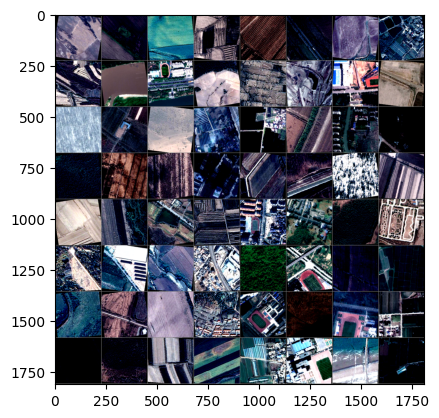

Image 1 : CultivatedLand
Image 2 : CultivatedLand ForestLand
Image 3 : CultivatedLand
Image 4 : CultivatedLand Highway
Image 5 : CultivatedLand
Image 6 : CultivatedLand ForestLand Highway
Image 7 : CultivatedLand
Image 8 : CultivatedLand ForestLand Lakes ResidentialArea
Image 9 : CultivatedLand
Image 10 : ForestLand Highway Rivers
Image 11 : FootballField ForestLand Highway ResidentialArea Rivers
Image 12 : CultivatedLand ForestLand
Image 13 : CultivatedLand
Image 14 : CultivatedLand Lakes
Image 15 : FactoryBuilding FootballField ForestLand ResidentialArea
Image 16 : CultivatedLand Lakes
Image 17 : ForestLand
Image 18 : CultivatedLand FactoryBuilding ForestLand
Image 19 : ForestLand
Image 20 : CultivatedLand ForestLand Greenhouse ResidentialArea
Image 21 : CultivatedLand ForestLand Lakes ResidentialArea
Image 22 : CultivatedLand ForestLand
Image 23 : FootballField ForestLand ResidentialArea Rivers
Image 24 : CultivatedLand ForestLand Highway
Image 25 : ForestLand
Image 26 : CultivatedL

In [7]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy() # 删除了对图像的反正规化操作
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
# 获取一些随机训练图像
train_dataloader = MultiSceneClean.train_dataloader()
images, labels = next(iter(train_dataloader))

# 显示图像
imshow(torchvision.utils.make_grid(images))

# 由于是多标签分类，我们需要修改标签的显示方式
def print_labels(labels):
    # 假设我们有一个类别列表，这应当在你的数据模块或某处被定义
    classes = MultiSceneClean.classes
    batch_labels = labels.numpy()
    for i in range(batch_labels.shape[0]):
        # 对于每个样本，找出是正类的标签
        label_indexes = np.where(batch_labels[i] == 1)[0]
        label_names = [classes[idx] for idx in label_indexes]
        print('Image', i+1, ':', ' '.join(label_names))

# 打印标签
print_labels(labels)

# 2 模型训练

2.1 网络结构

In [8]:
from torch import nn

class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # 分别计算正负例的概率
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # 非对称裁剪
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)  # 给 self.xs_neg 加上 clip 值

        # 先进行基本交叉熵计算
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
                
            # 以下 4 行相当于做了个并行操作
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


In [9]:
import math


class AveragePrecisionMeter(object):

    def __init__(self):
        super(AveragePrecisionMeter, self).__init__()
        self.reset()

    def reset(self):
        """Resets the meter with empty member variables"""
        self.scores = torch.FloatTensor(torch.FloatStorage())
        self.targets = torch.LongTensor(torch.LongStorage())

    def add(self, output, target):
        """
        concatenate samples of the new batch and previous batches
        Args:
            output: predicted multiple labels, should be an NxK tensor, postive/negative means presence/absence
            target: ground truth multiple labels, should be an NxK binary tensors, each is multi-hot
        Notes:
            N: the number of samples
            K: the number of classes
        """
        if not torch.is_tensor(output):
            output = torch.from_numpy(output)
        if not torch.is_tensor(target):
            target = torch.from_numpy(target)

        if output.dim() == 1:
            output = output.view(-1, 1)
        else:
            assert output.dim() == 2, \
                'wrong output size (should be 1D or 2D with one column \
                per class)'
        if target.dim() == 1:
            target = target.view(-1, 1)
        else:
            assert target.dim() == 2, \
                'wrong target size (should be 1D or 2D with one column \
                per class)'
        if self.scores.numel() > 0:
            assert target.size(1) == self.targets.size(1), \
                'dimensions for output should match previously added examples.'

        # make sure storage is of sufficient size
        if self.scores.untyped_storage().size() < self.scores.numel() + output.numel():
            new_size = math.ceil(self.scores.untyped_storage().size() * 1.5)
            self.scores.untyped_storage().resize_(int(new_size + output.numel()))
            self.targets.untyped_storage().resize_(int(new_size + output.numel()))

        # store scores and targets
        offset = self.scores.size(0) if self.scores.dim() > 0 else 0
        self.scores = self.scores.detach()  # 解除梯度跟踪
        self.targets = self.targets.detach()  # 解除梯度跟踪
        self.scores.resize_(offset + output.size(0), output.size(1))
        self.targets.resize_(offset + target.size(0), target.size(1))
        self.scores.narrow(0, offset, output.size(0)).copy_(output)
        self.targets.narrow(0, offset, target.size(0)).copy_(target)

    def value(self):
        """Returns the model's average precision for each class
        Return:
            ap (FloatTensor): 1xK tensor, with avg precision for each class k
        """

        if self.scores.numel() == 0:
            return 0
        self.scores_nonzero = self.scores[:, self.targets.sum(axis=0)>0]
        self.targets_nonzero = self.targets[:, self.targets.sum(axis=0)>0]
        ap = torch.zeros(self.scores_nonzero.size(1))
        rg = torch.arange(1, self.scores_nonzero.size(0)).float()
        # compute average precision for each class
        for k in range(self.scores_nonzero.size(1)):
            # sort scores
            scores = self.scores_nonzero[:, k]
            targets = self.targets_nonzero[:, k]
            # compute average precision
            ap[k] = AveragePrecisionMeter.average_precision(scores, targets)
        return ap

    @staticmethod
    def average_precision(output, target):
        # sort examples
        sorted, indices = torch.sort(output, dim=0, descending=True)

        # Computes prec@i
        pos_count = 0.
        total_count = 0.
        precision_at_i = 0.
        for i in indices:
            label = target[i]
            if label == 1:
                pos_count += 1
            total_count += 1
            if label == 1:
                precision_at_i += pos_count / total_count
        if pos_count==0:
            precision_at_i = 0
        else:
            precision_at_i /= pos_count
        return precision_at_i

    def overall(self):
        if self.scores.numel() == 0:
            return 0
        scores = self.scores.cpu().numpy()
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        return self.evaluation(scores, targets)

    def overall_topk(self, k):
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        n, c = self.scores.size()
        scores = np.zeros((n, c)) - 1
        index = self.scores.topk(k, 1, True, True)[1].cpu().numpy()
        tmp = self.scores.cpu().numpy()
        for i in range(n):
            for ind in index[i]:
                scores[i, ind] = 1 if tmp[i, ind] >= 0 else -1
        return self.evaluation(scores, targets)

    def evaluation(self, scores_, targets_):
        """Returns the model's OP, OR, OF1, CP, CR, CF1, EP, ER, EF1
            Return:
            OP, OR, OF1, CP, CR, CF1, EP, ER, EF1: 9 Float tensors
        """
        eps = 1e-10
        n, n_class = scores_.shape
        Nc, Np, Ng = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
        for k in range(n_class):
            scores = scores_[:, k]
            targets = targets_[:, k]
            targets[targets == -1] = 0
            Ng[k] = np.sum(targets == 1)
            Np[k] = np.sum(scores >= 0)
            Nc[k] = np.sum(targets * (scores >= 0))

        OP = np.sum(Nc) / (np.sum(Np) + eps)
        OR = np.sum(Nc) / (np.sum(Ng) + eps)
        OF1 = (2 * OP * OR) / (OP + OR + eps)

        CP = Nc / (Np + eps)
        CR = Nc / (Ng + eps)
        CF1 = (2 * CP * CR) / ( CP + CR + eps)

        CP = np.mean(CP)
        CR = np.mean(CR)
        CF1 = np.mean(CF1)

        # calculate example-based
        pred = np.int8(np.round(1/(1+np.exp(-scores_))))
        gt = np.int8(np.round(targets_))
        TP_e = np.float32(np.sum(((pred+gt) == 2), 1))
        FP_e = np.float32(np.sum(((pred-gt) == 1), 1))
        FN_e = np.float32(np.sum(((pred-gt) == -1), 1))
        TN_e = np.float32(np.sum(((pred+gt) == 0), 1))

        # clear TP_e is 0, assign it some value and latter assign zero
        Nc = TP_e
        Np = TP_e + FP_e
        Ng = TP_e + FN_e

        EP = Nc / (Np + eps)
        ER = Nc / (Ng + eps)
        EF1 = (2 * EP * ER) / (EP + ER + eps)

        EP = np.mean(EP)
        ER = np.mean(ER)
        EF1 = np.mean(EF1)

        return OP, OR, OF1, CP, CR, CF1, EP, ER, EF1 

In [10]:
from typing import Optional
import os
import torch
from torch import nn
from torchvision import models
import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall, F1Score, MetricCollection
from torchmetrics.classification import MultilabelAccuracy
from transformers import ViTConfig, ViTModel, ViTForImageClassification
from sklearn.metrics import average_precision_score
import numpy as np

In [11]:
class MyCLSModel(pl.LightningModule):
    def __init__(self, model_name, pretrained_status, criterion="BCE", learning_rate=0.05, num_classes=10):  # num_classes should be passed as an argument
        super().__init__()
        self.save_hyperparameters()
        
        self.model_name = model_name
        self.pretrained = pretrained_status
        self.criterion = criterion
        
        if self.model_name == 'VGG16': # VGG16
            self.model = models.vgg16(pretrained=self.pretrained)
            self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        elif self.model_name == 'resnet50': # ResNet
            self.model = models.resnet50(pretrained=self.pretrained)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif self.model_name == 'ViT-b': # ViT
            if self.pretrained:
                self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_classes)
            else:
                config = ViTConfig(image_size=224, patch_size=16, num_channels=3, num_labels=num_classes)
                self.model = ViTForImageClassification(config)
        elif self.model_name == 'ResNeXt50': # ResNeXt
            self.model = models.resnext50_32x4d(pretrained=self.pretrained)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif self.model_name == 'ResNeXt101':  # ResNext101
            self.model = models.resnext101_32x8d(pretrained=self.pretrained)  # 使用预训练权重或不使用
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)


        # self.criterion = nn.CrossEntropyLoss()
        if self.criterion == "BCE":
            self.criterion = nn.BCEWithLogitsLoss()
        elif self.criterion == "ASL":
            self.criterion = AsymmetricLossOptimized()
        
        # self.train_accuracy = Accuracy(task="multilabel", num_labels=num_classes)
        self.train_accuracy = MultilabelAccuracy(num_labels=num_classes)
        self.val_accuracy = MultilabelAccuracy(num_labels=num_classes)
        self.test_accuracy = MultilabelAccuracy(num_labels=num_classes)

        self.average_precision_meter = AveragePrecisionMeter()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.model_name == 'ViT-b':
            outputs = self(x)
            logits = outputs.logits 
        else: 
            logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_accuracy(logits, y)
        
        # 添加样本到评估类中
        # self.average_precision_meter.add(logits, y)  # 不需要在训练步骤中更新 mAP        
        
        # self.log("train_loss", loss)
        # self.log("train_accuracy", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if self.model_name == 'ViT-b':
            outputs = self(x)
            logits = outputs.logits 
        else: 
            logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.val_accuracy(logits, y)
        
        # 添加样本到评估类中
        self.average_precision_meter.add(logits, y)
        
        # self.log("val_loss", loss)
        # self.log("val_accuracy", acc)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, on_epoch=True, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        if self.model_name == 'ViT-b':
            outputs = self(x)
            logits = outputs.logits 
        else: 
            logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.test_accuracy(logits, y)
        
        # 添加样本到评估类中
        self.average_precision_meter.add(logits, y)
        
        # self.log("test_accuracy", acc)
        # self.log("test_loss", loss)
        self.log("test_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def on_validation_epoch_end(self):
        # 计算并记录性能指标
        ap_values = self.average_precision_meter.value()
        self.log('val_mAP', ap_values.mean()*100, prog_bar=True, logger=True)
        
        for i, ap_value in enumerate(ap_values):
            self.log(f'val_AP_class_{i}', ap_value, prog_bar=True, logger=True)
        # self.log('val_per-class AP:', ap_values*100, prog_bar=True, logger=True)
        
        op, or_, of1, cp, cr, cf1, ep, er, ef1 = self.average_precision_meter.overall()
        self.log('test_OP', op*100, prog_bar=True, logger=True)
        self.log('test_OR', or_*100, prog_bar=True, logger=True)
        self.log('test_OF1', of1*100, prog_bar=True, logger=True)
        self.log('test_CP', cp*100, prog_bar=True, logger=True)
        self.log('test_CR', cr*100, prog_bar=True, logger=True)
        self.log('test_CF1', cf1*100, prog_bar=True, logger=True)
        self.log('test_EP', ep*100, prog_bar=True, logger=True)
        self.log('test_ER', er*100, prog_bar=True, logger=True)
        self.log('test_EF1', ef1*100, prog_bar=True, logger=True)
        
        self.average_precision_meter.reset()

    def on_test_epoch_end(self):
        # 计算并记录性能指标
        ap_values = self.average_precision_meter.value()
        self.log('test_mAP', ap_values.mean()*100, prog_bar=True, logger=True)
        
        for i, ap_value in enumerate(ap_values):
            self.log(f'test_AP_class_{i}', ap_value, prog_bar=True, logger=True)
        # self.log('test_per-class AP:', ap_values*100, prog_bar=True, logger=True)

        op, or_, of1, cp, cr, cf1, ep, er, ef1 = self.average_precision_meter.overall()
        self.log('test_OP', op*100, prog_bar=True, logger=True)
        self.log('test_OR', or_*100, prog_bar=True, logger=True)
        self.log('test_OF1', of1*100, prog_bar=True, logger=True)
        self.log('test_CP', cp*100, prog_bar=True, logger=True)
        self.log('test_CR', cr*100, prog_bar=True, logger=True)
        self.log('test_CF1', cf1*100, prog_bar=True, logger=True)
        self.log('test_EP', ep*100, prog_bar=True, logger=True)
        self.log('test_ER', er*100, prog_bar=True, logger=True)
        self.log('test_EF1', ef1*100, prog_bar=True, logger=True)
        
        self.average_precision_meter.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, momentum=0.9, weight_decay=1e-4)
        return optimizer


In [12]:
# model

num_cls = MultiSceneClean.num_classes
model = MyCLSModel(model_name, pretrained_status, criterion, learning_rate=0.02, num_classes=num_cls)


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_244953/1561183709.py:12: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  self.scores = torch.Floa

## 2.2 训练模型

In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_dir = 'ckpt/'

# 设置模型检查点回调以保存mAP最高的前三个模型
checkpoint_callback = ModelCheckpoint(
    monitor='val_mAP',
    dirpath=checkpoint_dir,
    filename=f'{model_name}-{pretrained_status}-{criterion}-{{epoch:02d}}-{{val_mAP:.4f}}',
    save_top_k=3,
    mode='max',
)

# 设置早停回调，如果验证集loss在连续10个epoch内没有提高，则停止训练
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode='min'
)


In [14]:
trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
    devices=1,
    logger=TensorBoardLogger(save_dir=f"logs/train/{model_name}"),
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stop_callback
    ],
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
train_dataloader = MultiSceneClean.train_dataloader()
val_dataloader = MultiSceneClean.val_dataloader()
trainer.fit(model, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/train/ResNeXt101/lightning_logs
/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /root/autodl-tmp/RSMLR/ckpt exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model          │ ResNet             │ 86.8 M │
│ 1 │ criterion      │ BCEWithLogitsLoss  │      0 │
│ 2 │ train_accuracy │ MultilabelAccuracy │      0 │
│ 3 │ val_accuracy   │ MultilabelAccuracy │      0 │
│ 4 │ test_accuracy  │ MultilabelAccuracy │      0 │
└───┴────────────────┴────────────────────┴────────┘

Trainable params: 86.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 86.8 M                                                                                               
Total estimated model params size (MB): 347

Output()

/tmp/ipykernel_244953/1561183709.py:12: UserWarning: TypedStorage is deprecated. It will be removed in the future 
and UntypedStorage will be the only storage class. This should only matter to you if you are using storages 
directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  self.scores = torch.FloatTensor(torch.FloatStorage())

/tmp/ipykernel_244953/1561183709.py:13: UserWarning: TypedStorage is deprecated. It will be removed in the future 
and UntypedStorage will be the only storage class. This should only matter to you if you are using storages 
directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  self.targets = torch.LongTensor(torch.LongStorage())

# 3 模型评估

In [16]:
import os

checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) 
               if f.endswith('.ckpt') and f.startswith(model_name)]

def extract_val_accuracy(filename):
    parts = filename.split('-')
    for part in parts:
        if part.startswith("val_mAP="):
        # if part.startswith("val_accuracy="):

            accuracy_str = part.split('=')[1]
            try:
                return float(accuracy_str)
            except ValueError:
                return 0.0
    return 0.0

top_checkpoints = sorted(checkpoints, key=extract_val_accuracy, reverse=True)[:3]

test_dataloader = MultiSceneClean.test_dataloader()
top_checkpoints

['ckpt/ResNeXt101-True-BCE-epoch=11-val_mAP=56.8836.ckpt',
 'ckpt/ResNeXt101-True-BCE-epoch=13-val_mAP=57.0575.ckpt',
 'ckpt/ResNeXt101-True-BCE-epoch=12-val_mAP=58.0988.ckpt']

In [17]:
# 加载每个模型并测试
for checkpoint_path in top_checkpoints:
    # 加载模型
    model = MyCLSModel.load_from_checkpoint(checkpoint_path)
    
    # 创建一个新的训练器实例进行测试，确保不会使用旧的状态或回调
    tester = pl.Trainer(
        accelerator="auto",
        devices=1,
        logger=TensorBoardLogger(save_dir=f"logs/test/{model_name}"),

    )
    
    # 使用测试数据集进行测试
    tester.test(model, dataloaders=test_dataloader)


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_244953/1561183709.py:12: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  self.scores = torch.Floa

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_AP_class_0      │   0.0005691519472748041   │
│      test_AP_class_1      │    0.9131293296813965     │
│     test_AP_class_10      │     0.904090166091919     │
│     test_AP_class_11      │    0.7143428921699524     │
│     test_AP_class_12      │    0.1544957309961319     │
│     test_AP_class_13      │   0.035777557641267776    │
│     test_AP_class_14      │    0.3976212441921234     │
│     test_AP_class_15      │  0.00044802867341786623   │
│     test_AP_class_16      │    0.07885344326496124    │
│     test_AP_class_17      │    0.9780582189559937     │
│     test_AP_class_18      │    0.8235774636268616     │
│     test_AP_class_19      │     0.155513197183609     │
│      test_AP_class_2      │   0.0005552145303227007   │
│     test_AP_class_20      │    0.2596272826194763     │
│      test_AP_class_3      │    0.9791032671928406     │
│      test_AP_class_4      │    0.8454759120941162     │
│      test_AP_class_5      │    0.9812468886375427     │
│      test_AP_class_6      │     0.937781035900116     │
│      test_AP_class_7      │    0.35513579845428467    │
│      test_AP_class_8      │    0.3010771572589874     │
│      test_AP_class_9      │    0.8646078705787659     │
│         test_CF1          │     45.10738754272461     │
│          test_CP          │     55.8736457824707      │
│          test_CR          │     41.47612380981445     │
│         test_EF1          │     84.74813842773438     │
│          test_EP          │     89.28099060058594     │
│          test_ER          │     83.96438598632812     │
│         test_OF1          │     84.97999572753906     │
│          test_OP          │     88.27603912353516     │
│          test_OR          │     81.92123413085938     │
│       test_accuracy       │    0.9633995890617371     │
│         test_loss         │    0.11678092926740646    │
│         test_mAP          │     50.86232376098633     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_AP_class_0      │   0.0005128204938955605   │
│      test_AP_class_1      │    0.9030001759529114     │
│     test_AP_class_10      │    0.8977319598197937     │
│     test_AP_class_11      │    0.6987593770027161     │
│     test_AP_class_12      │    0.10327471792697906    │
│     test_AP_class_13      │    0.10312098264694214    │
│     test_AP_class_14      │    0.4117419719696045     │
│     test_AP_class_15      │   0.0003822630096692592   │
│     test_AP_class_16      │    0.12481202930212021    │
│     test_AP_class_17      │    0.9733792543411255     │
│     test_AP_class_18      │     0.822229266166687     │
│     test_AP_class_19      │    0.11745868623256683    │
│      test_AP_class_2      │   0.0010006914380937815   │
│     test_AP_class_20      │    0.2270951271057129     │
│      test_AP_class_3      │    0.9790061116218567     │
│      test_AP_class_4      │    0.8241796493530273     │
│      test_AP_class_5      │    0.9849838018417358     │
│      test_AP_class_6      │    0.9395493865013123     │
│      test_AP_class_7      │    0.31884902715682983    │
│      test_AP_class_8      │    0.36143141984939575    │
│      test_AP_class_9      │    0.8636752963066101     │
│         test_CF1          │    43.694366455078125     │
│          test_CP          │     54.50407028198242     │
│          test_CR          │     40.26702117919922     │
│         test_EF1          │     84.15147399902344     │
│          test_EP          │     89.63444519042969     │
│          test_ER          │     82.64146423339844     │
│         test_OF1          │     84.43242645263672     │
│          test_OP          │     89.04589080810547     │
│          test_OR          │     80.2734603881836      │
│       test_accuracy       │    0.9625871777534485     │
│         test_loss         │    0.12765339016914368    │
│         test_mAP          │     50.74368667602539     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_AP_class_0      │   0.0009718172950670123   │
│      test_AP_class_1      │    0.9076572060585022     │
│     test_AP_class_10      │    0.8990673422813416     │
│     test_AP_class_11      │    0.7115136981010437     │
│     test_AP_class_12      │    0.11877045780420303    │
│     test_AP_class_13      │    0.14011292159557343    │
│     test_AP_class_14      │    0.42220136523246765    │
│     test_AP_class_15      │   0.0003588087565731257   │
│     test_AP_class_16      │    0.10048701614141464    │
│     test_AP_class_17      │    0.9750906825065613     │
│     test_AP_class_18      │    0.8135825395584106     │
│     test_AP_class_19      │    0.1287679225206375     │
│      test_AP_class_2      │   0.0008495007641613483   │
│     test_AP_class_20      │    0.2659896910190582     │
│      test_AP_class_3      │    0.9790154099464417     │
│      test_AP_class_4      │     0.836113691329956     │
│      test_AP_class_5      │     0.987462043762207     │
│      test_AP_class_6      │     0.943410336971283     │
│      test_AP_class_7      │    0.3204152286052704     │
│      test_AP_class_8      │    0.3296761214733124     │
│      test_AP_class_9      │    0.8656243085861206     │
│         test_CF1          │    44.764251708984375     │
│          test_CP          │     55.24357223510742     │
│          test_CR          │    41.463714599609375     │
│         test_EF1          │     84.43323516845703     │
│          test_EP          │      89.35107421875       │
│          test_ER          │     83.40966033935547     │
│         test_OF1          │     84.79307556152344     │
│          test_OP          │     88.61146545410156     │
│          test_OR          │     81.29016876220703     │
│       test_accuracy       │    0.9631484746932983     │
│         test_loss         │    0.11958352476358414    │
│         test_mAP          │     51.17685317993164     │
└───────────────────────────┴───────────────────────────┘